# <center>Finding a suitable property zone base on the venue of neighborhood and real estate values  <br> 
### <center>Applied Data Science Capstone by IBM/Coursera<br>
### <center>Nicolas Marrugo

# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

The report given by ** the CBRE Econometric Advisors since 2017**, the U.S homeownership rate is stable around **63.7%**, after some years of recovering from the drop of the global financial crisis of 2007-2008. But although this rate is quite stable in cities like New York City and Boston, according with the 2018 homebuyer report driven by **Nerdwallet **, discovered that 75%** of North Americans still say that have a house is a top priority**, but approximately just **15% of the people reported had purchased a home in the past five year**s, and 32% intend to do so in the next half-decade.

Ones of the reasons why the market have this behavior are basically due to the **lack of inventory of houses, limited construction of new houses, construction of luxury properties, having zones with rules that restrict a higher density development or simple that investors keep the new acquisitions as rentals**. This lead to have a real challenge in order to find a **suitable house that fulfill the desires of the client in terms of location, price and neighborhood**.

Taking into account the previous statements, this project has the aim of **determine the set of neighborhoods that share some similar venues (restaurants, caffe, supermarket, banks, bar, etc.) and have a reasonable similar real estate price with its tendency of growth (+%) or fall (-%)**. In order to give a reference tool for a client that want to buy a new house, **select optimal neighborhoods that will fulfill the location, average price of a house and real estate index desires.**


## Importing libraries need it

In [646]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth=100
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
# prepocessing librery for normalization
from sklearn import preprocessing

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import dictionary operators
import operator

# import the library to plot dataframe
from tabulate import tabulate
print('Libraries imported.')

Libraries imported.


# Data <a name="data"></a>

For developing this project is factor that will impact in the result of the project are:

* Location of each New York neighborhood.
* Existing Venues in a radius of 500 mts of the center of each neighborhood.
* Real estate price of a house for each neighborhood.
* Historical data for the real estate price of each neighborhood.

In order to gather this information, the following database were used:

* Real estate data of the **New York Times listings database and the New York City government records.**
* number of venues and their location in every neighborhood using **Foursquare API.**
* Location data is given by the **New York (City), Department of City Planning.**


## Importing data from database

This is the data related with **5 boroughs and 306 neighborhoods of New York**, the dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood.

In [255]:
#Request for the Json File that conatins the location data
NewYorkDataJson = requests.get('https://cocl.us/new_york_dataset').json()

Notice how all the relevant data is in the **features** key, which is basically a list of the neighborhoods in the json file. 

In [256]:
#Selecte the relevant information from Json file
neighborhoods_data = NewYorkDataJson['features']

In [564]:
#First neighborhood data
neighborhoods_data[0]

{u'geometry': {u'coordinates': [-73.84720052054902, 40.89470517661],
  u'type': u'Point'},
 u'geometry_name': u'geom',
 u'id': u'nyu_2451_34572.1',
 u'properties': {u'annoangle': 0.0,
  u'annoline1': u'Wakefield',
  u'annoline2': None,
  u'annoline3': None,
  u'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  u'borough': u'Bronx',
  u'name': u'Wakefield',
  u'stacked': 1},
 u'type': u'Feature'}

## Tranform the location data into a *pandas* dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe with the columns defined
neighborhoods = pd.DataFrame(columns=column_names)

The next task is essentially transforming this data of nested Python dictionaries from the json file into a pandas dataframe.

In [7]:
for data in neighborhoods_data:
    #get the borough for each json data
    borough = neighborhood_name = data['properties']['borough'] 
    #get the neighborhood name for each json data
    neighborhood_name = data['properties']['name']
    #get the latitude and longitude for each json data    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    #save all the variables in the dataframe call 'neighborhoods' 
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [258]:
#sort the values of the location data
neighborhoods=neighborhoods.sort_values(['Borough','Neighborhood']).reset_index().drop(['index'],axis=1)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Allerton,40.865788,-73.859319
1,Bronx,Baychester,40.866858,-73.835798
2,Bronx,Bedford Park,40.870185,-73.885512
3,Bronx,Belmont,40.857277,-73.888452
4,Bronx,Bronxdale,40.852723,-73.861726


In [259]:
#checking that all the data was converted 
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


## visualization of the location data usinf folium

Use geopy library to get the latitude and longitude values of New York City.

In [260]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


Create a map of New York with neighborhoods superimposed on top.

In [261]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Importing the real estate data from csv file

This is the information provided by the **New York Times listings database and the New York City government records**, which contains **real estate data from the last year, the last 3 months and the current day sales price for 286 neighborhoods in New York**. This data set was **rearranged** in order to meet the 306 neighborhoods real estate price of each neighborhood in the location data**.

In [12]:
# importing dataframe with the real state data
RealEstateData=pd.read_csv('NYneighborhoods.csv')

In [13]:
RealEstateData.head()

,Borough,Neighborhood,Price 1 y ago,price 3 month ago,price now,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Bronx,Allerton,"414,917","260,583","267,667",NaN,NaN,NaN,NaN,NaN
1,Bronx,Baychester,"500,833","484,722","549,583",NaN,NaN,NaN,NaN,NaN
2,Bronx,Bedford Park,"279,940","306,488","315,654",NaN,NaN,NaN,NaN,NaN
3,Bronx,Belmont,"459,252","503,292","578,492",NaN,NaN,NaN,NaN,NaN
4,Bronx,Bronxdale,"196,201","164,083","158,250",NaN,NaN,NaN,NaN,NaN


## Transformig and cleaning the data 

Is necessary to drop the columns with NaN values

In [14]:
#function for drop the columns with NaN values
RealEstateData.dropna(axis=1,inplace=True)
RealEstateData.head()

,Borough,Neighborhood,Price 1 y ago,price 3 month ago,price now
0,Bronx,Allerton,"414,917","260,583","267,667"
1,Bronx,Baychester,"500,833","484,722","549,583"
2,Bronx,Bedford Park,"279,940","306,488","315,654"
3,Bronx,Belmont,"459,252","503,292","578,492"
4,Bronx,Bronxdale,"196,201","164,083","158,250"


Due to the values in the columns are recognize as string for the comma instead of the point, is necessary to do a **transformation** and in this way make the corresponding **normalization**

In [15]:
# define a function to transform the real estate data into a integer
def transFormToInt (column):
    var=[]
    #get the value of each row in the column
    for value in column:
        #erase the "," on each value
        d=int(str(value).replace(",",""))
        #create a list of the new values
        var.append(d)
    # create a dataframe with the list of the new values
    PdData = pd.DataFrame([item for item in var])
    PdData.columns=[column.name]
    # Normalize values 
    x = PdData.values #returns a numpy array
    # call the min mas normalize function
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    # save the data normalize in a dataframe
    df = pd.DataFrame(x_scaled)
    df.columns=[column.name+'Normal']
    df[column.name]=PdData
    return  df

In [16]:
# call the function for each column
var=transFormToInt(RealEstateData['Price 1 y ago'])
var2=transFormToInt(RealEstateData['price 3 month ago'])
var3=transFormToInt(RealEstateData['price now'])
final=var.join(var2).join(var3)

# merge the new columns with the real estate location
RealEstateData=RealEstateData[['Borough','Neighborhood']].join(final)

/Users/Marrugo/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
RealEstateData.head()

,Borough,Neighborhood,Price 1 y agoNormal,Price 1 y ago,price 3 month agoNormal,price 3 month ago,price nowNormal,price now
0,Bronx,Allerton,0.055221,414917,0.016108,260583,0.012022,267667
1,Bronx,Baychester,0.070238,500833,0.051738,484722,0.042995,549583
2,Bronx,Bedford Park,0.031627,279940,0.023405,306488,0.017294,315654
3,Bronx,Belmont,0.062970,459252,0.054690,503292,0.046172,578492
4,Bronx,Bronxdale,0.016990,196201,0.000768,164083,0.000000,158250


In [18]:
#checking that all the data was converted 
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(RealEstateData['Borough'].unique()),
        RealEstateData.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


## Adding real estate price percentage 

The percentage of price change from the price 12 months ago and the price 3 months ago

In [649]:
#function for calculate the real estate percentage for each column
def RealEstatePercentage(column1,column2,name):
    percentage=[]
    # get the price of each row for both columns
    for valueOld, valueNew in zip (column1,column2):
        perc=(float(valueNew-valueOld)/(valueNew))*100
        # create a list with the index values
        
        percentage.append(perc)
    #create a dataframe with the index list
    Pdperc = pd.DataFrame([item for item in percentage])
    # rename the column in the dataframe 
    Pdperc.columns=['Real estate percentage '+name]
    return Pdperc

In [650]:
percentage=RealEstateData

In [651]:
# call the function for each period
month3=RealEstatePercentage(percentage['price 3 month ago'],percentage['price now'],'3month ago')
month12=RealEstatePercentage(percentage['Price 1 y ago'],percentage['price now'],'12month ago')


In [652]:
# merge the percentage with the real estate data
percentage=percentage.join(month12).join(month3)#.join(indexReal)
percentage.head()

,Borough,Neighborhood,Price 1 y agoNormal,Price 1 y ago,price 3 month agoNormal,price 3 month ago,price nowNormal,price now,Real estate percentage 12month ago,Real estate percentage 3month ago
0,Bronx,Allerton,0.055221,414917,0.016108,260583,0.012022,267667,-55.012385,2.646572
1,Bronx,Baychester,0.070238,500833,0.051738,484722,0.042995,549583,8.870362,11.801857
2,Bronx,Bedford Park,0.031627,279940,0.023405,306488,0.017294,315654,11.314287,2.903812
3,Bronx,Belmont,0.062970,459252,0.054690,503292,0.046172,578492,20.612212,12.999315
4,Bronx,Bronxdale,0.016990,196201,0.000768,164083,0.000000,158250,-23.981675,-3.685940


## Adding real estate index

The trend in the behaviour of the average price of a house per each neighborhood

In [653]:
#function for calculate the real estate index for each column
def RealEstateIndex(column1,column2):
    index=[]
    # get the price of each row for both columns
    for value12, value3 in zip (column1,column2):
        if value12>0 and value3>0:
            if value12>value3:
                ind='Negative trend (-%) and an appreciation on the average price of +'+str(round(value3,3))+'% in the last 3 months.'
            else:
                ind='Positive trend (+%) and an appreciation on the average price of +'+str(round(value3,3))+'% in the last 3 months.'
        elif value12<0 and value3<0:
            if value12>value3:
                ind='Negative trend (-%) and a depreciation on the average price of '+str(round(value3,3))+'% in the last 3 months.'
            else:
                ind='Positive trend (+%) and a depreciation on the average price of '+str(round(value3,3))+'% in the last 3 months.'
        elif value12<0 and value3>0:
                ind='Positive trend (+%) and an appreciation on the average price of +'+str(round(value3,3))+'% in the last 3 months.'
        elif value12>0 and value3<0:
                ind='Negative trend (-%) and a depreciation on the average price of '+str(round(value3,3))+'% in the last 3 months.'
        # create a list with the index values
        
        index.append(ind)
    #create a dataframe with the index list
    Pdindex = pd.DataFrame([item for item in index])
    # rename the column in the dataframe 
    Pdindex.columns=['Real state index']
    return Pdindex

In [654]:
indexReal=RealEstateIndex(percentage['Real estate percentage 12month ago'],percentage['Real estate percentage 3month ago'])

In [655]:
# merge the index with the real estate data
percentage=percentage.join(indexReal)
percentage.head()

,Borough,Neighborhood,Price 1 y agoNormal,Price 1 y ago,price 3 month agoNormal,price 3 month ago,price nowNormal,price now,Real estate percentage 12month ago,Real estate percentage 3month ago,Real state index
0,Bronx,Allerton,0.055221,414917,0.016108,260583,0.012022,267667,-55.012385,2.646572,Positive trend (+%) and an appreciation on the average price of +2.647% in the last 3 months.
1,Bronx,Baychester,0.070238,500833,0.051738,484722,0.042995,549583,8.870362,11.801857,Positive trend (+%) and an appreciation on the average price of +11.802% in the last 3 months.
2,Bronx,Bedford Park,0.031627,279940,0.023405,306488,0.017294,315654,11.314287,2.903812,Negative trend (-%) and an appreciation on the average price of +2.904% in the last 3 months.
3,Bronx,Belmont,0.062970,459252,0.054690,503292,0.046172,578492,20.612212,12.999315,Negative trend (-%) and an appreciation on the average price of +12.999% in the last 3 months.
4,Bronx,Bronxdale,0.016990,196201,0.000768,164083,0.000000,158250,-23.981675,-3.685940,Positive trend (+%) and a depreciation on the average price of -3.686% in the last 3 months.


## Importing the Vanues information from foursquare

Defining the credentials to access the foursquared database

In [23]:
CLIENT_ID = '15KGYFXHGOMOWKSJOBEMTNUZHKQFVZ3SDKHG4CYHN1D0ZRVG' # your Foursquare ID
CLIENT_SECRET = 'B30FYT0RJIQ5RQ0Z51MPO024DYNBKDLLGQA45VK3MI0X3CJB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 15KGYFXHGOMOWKSJOBEMTNUZHKQFVZ3SDKHG4CYHN1D0ZRVG
CLIENT_SECRET:B30FYT0RJIQ5RQ0Z51MPO024DYNBKDLLGQA45VK3MI0X3CJB


## Explore Neighborhoods in New York

For exploring the **first 70 venues in a radius of 500mts** from the center of each neighborhoods in New york is necesary defined the following function

In [24]:
limit=70
radius=500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    #create a empty list that will store the venues
    venues_list=[]
    #iterating for each neighborhood getting the name, latitude and longitude
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print the name of each neighborhodd
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information like name of neighborhood, latitude, longitude, venue name,
        # venue latitude, venue longitude and venue category for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    # create a dataframe using the list created above for the venues
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
NewYork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Allerton
Baychester
Bedford Park
Belmont
Bronxdale
Castle Hill
City Island
Claremont Village
Clason Point
Co-op City
Concourse
Concourse Village
Country Club
East Tremont
Eastchester
Edenwald
Edgewater Park
Fieldston
Fordham
High  Bridge
Hunts Point
Kingsbridge
Kingsbridge Heights
Longwood
Melrose
Morris Heights
Morris Park
Morrisania
Mott Haven
Mount Eden
Mount Hope
North Riverdale
Norwood
Olinville
Parkchester
Pelham Bay
Pelham Gardens
Pelham Parkway
Port Morris
Riverdale
Schuylerville
Soundview
Spuyten Duyvil
Throgs Neck
Unionport
University Heights
Van Nest
Wakefield
West Farms
Westchester Square
Williamsbridge
Woodlawn
Bath Beach
Bay Ridge
Bedford Stuyvesant
Bensonhurst
Bergen Beach
Boerum Hill
Borough Park
Brighton Beach
Broadway Junction
Brooklyn Heights
Brownsville
Bushwick
Canarsie
Carroll Gardens
City Line
Clinton Hill
Cobble Hill
Coney Island
Crown Heights
Cypress Hills
Ditmas Park
Downtown
Dumbo
Dyker Heights
East Flatbush
East New York
East Williamsburg
Erasmus
Flatbush
Fl

## Check Venues of New York

In [26]:
# check the lenght of the dataframe with location and venues
print(NewYork_venues.shape)
NewYork_venues.head()

(9039, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allerton,40.865788,-73.859319,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place
1,Allerton,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant
2,Allerton,40.865788,-73.859319,Bronx Martial Arts Academy,40.865721,-73.857529,Martial Arts Dojo
3,Allerton,40.865788,-73.859319,Sal & Doms Bakery,40.865377,-73.855236,Dessert Shop
4,Allerton,40.865788,-73.859319,Dunkin Donuts,40.865204,-73.859007,Donut Shop


Determine the total number of venues per neighborhood

In [568]:
TotalVenues=NewYork_venues.groupby('Neighborhood')
TotalVenues.count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,27,27,27,27,27,27
Annadale,11,11,11,11,11,11
Arden Heights,4,4,4,4,4,4
Arlington,4,4,4,4,4,4
Arrochar,22,22,22,22,22,22


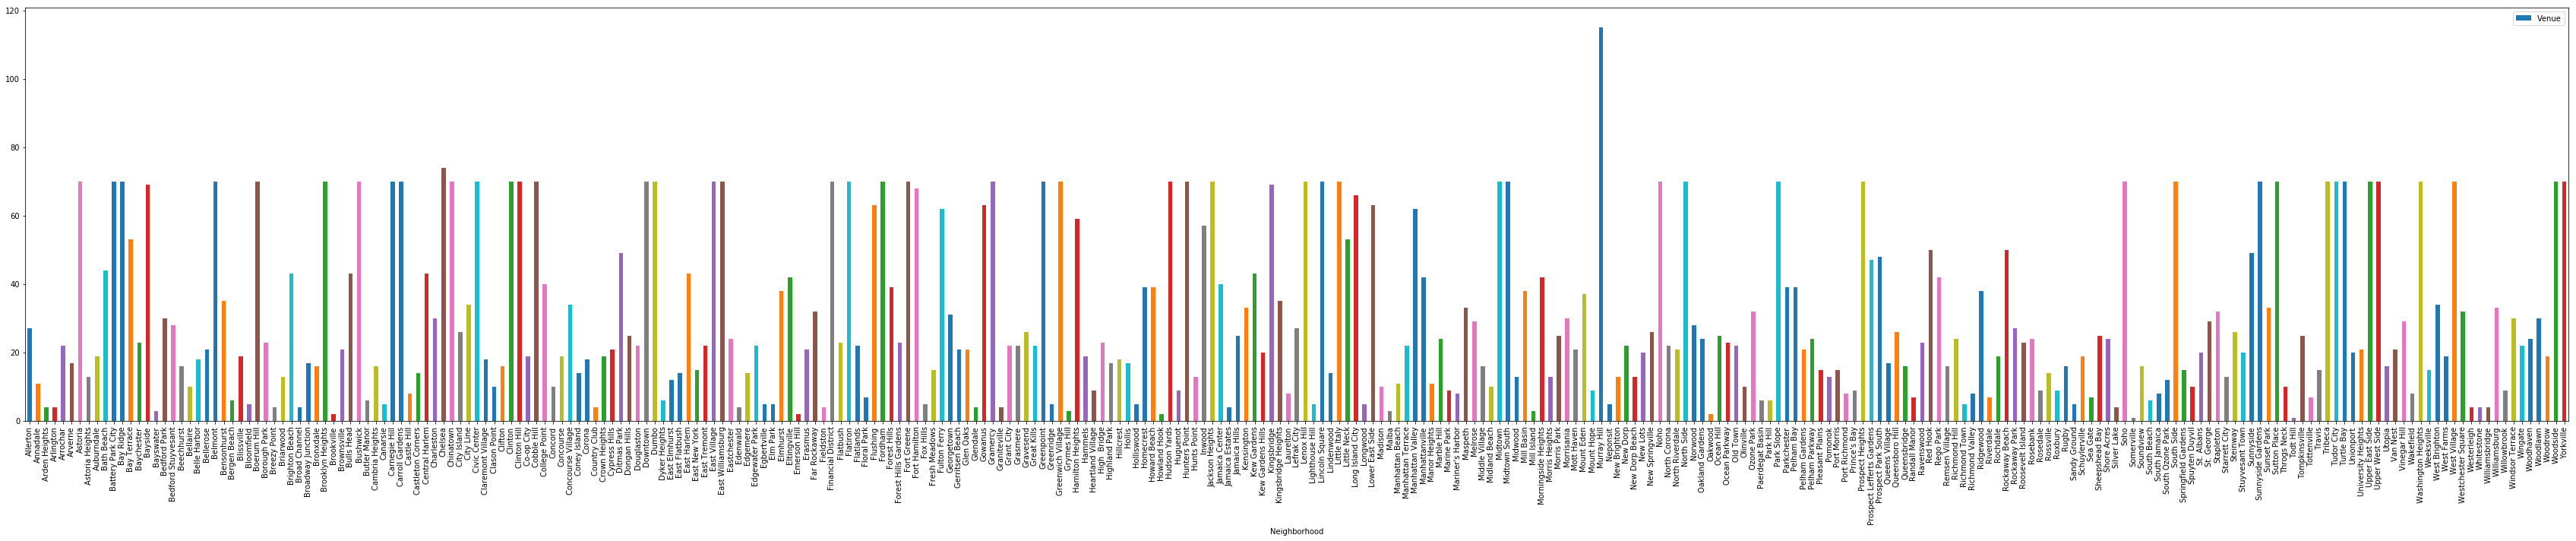

In [573]:
TotalVenues.count().plot(kind='bar', y='Venue', use_index=True, figsize=(60,10))

In [576]:
TotalVenues.count().mean()

Neighborhood Latitude     30.0299
Neighborhood Longitude    30.0299
Venue                     30.0299
Venue Latitude            30.0299
Venue Longitude           30.0299
Venue Category            30.0299
dtype: float64

the following distribution of the venues per neighborhood have a mean of 30 venues per neighborhood

# Methodology <a name="methodology"></a>

This project has the purpose of identify the set of neighborhoods in New York that share the same type of venues around of it and also have a similar average house price, with the purpose of give a list of different set in which will be characterize by the maximum and minimum average house price, the real estate index and also the type of venues that are common among them.

In order to develop this project, is necessary that after we have collected the required **data: location, real estate, venues** do the cleaning of the data, then estimate the real estate index based on the **average house price of 12 months ago and 3 months ago, and the following decisions:**


Value 1 | Value 2 | Condition | trend | Real estate Index
------- | ------- | --------- |------ | ------------------ 
>0	|>0	|Value 1 > Value 2	|Negative 	|Appreciation|
<0	|<0	|Value 1 > Value 2	|Negative 	|Depreciation|
<0	|>0	|Value 1 < Value 2	|Positive 	|Appreciation|
>0	|<0	|Value 1 > Value 2	|Negative 	|Depreciation|
>0	|>0	|Value 1 < Value 2	|Positive	|Appreciation|
<0	|<0	|Value 1 <Value 2	|Positive	|Depreciation|


Once the real estate index is calculated, is necessary get the **categorical values** of the venues for each neighborhood, identifying that the dataset from foursquare have **416 unique categories.** With the categorical values is possible to identify the probability of appearance of each category per neighborhood, and in this way identify the **top 10 venues with highest probability in each neighborhood in New Yok**.

Once all the data are rearranged together, in order to identify the set of neighborhoods in New Yok that share similar venues around and similar average house price, the most promising machine learning that would identify this sets is **k-means clustering**. The machine learning algorithm will analyze the **10 most common venues** in a radius of **500 meters of the center of each neighborhood**, and the **average price of the house** in that neighborhood, to separate the total features data ** (location data, real estate data, venues data)** in 8 clusters. This number of clusters was selected after trying different numbers from **5 to 20** and identify that the best clustering in **order to avoid cluster with 1 neighborhood was 8 clusters.**

Finally, the cluster that is presented to the user in a map with all the cluster and sorted from the most economic neighborhood to the most expensive one, and also the information is divide by cluster, where each cluster present the **borough, name, latitude, longitude and number of neighborhoods** on it, the **maximum and minimum average house price**, the **minimum and maximum percentage** of the price with respect the higher one New York, the **top 4 venues more common** on all the neighborhoods in the cluster and the **real estate index** of each neighborhood. This information is presented using the **folium** library and also as a printed dataframe. 


## Analyzing Each Neighborhood of New York

In [27]:
# one hot encoding
NewYorkEncoding = pd.get_dummies(NewYork_venues[['Venue Category']], prefix="", prefix_sep="")

# drop the neighborhood dummie column
NewYorkEncoding=NewYorkEncoding.drop(['Neighborhood'], axis=1)
# add neighborhood column back to dataframe
NewYorkEncoding['Neighborhood'] = NewYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NewYorkEncoding.columns[-1]] + list(NewYorkEncoding.columns[:-1])
NewYorkEncoding = NewYorkEncoding[fixed_columns]

NewYorkEncoding.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet 

Grouping by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [214]:
NewYorkVenuesNeighborhood = NewYorkEncoding.groupby('Neighborhood').mean().reset_index()
NewYorkVenuesNeighborhood.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet 

Defining a function to add the real estate values

In [215]:
def RealEstateValue(column,data):
    table=data
    # get the row of each column
    for name in column:
        # get the real estate price by the name of neighborhood
        price=RealEstateData.loc[RealEstateData['Neighborhood'] == name]['price nowNormal']
        # get the index of the neighborhood in the data
        index=table.loc[table['Neighborhood']==name].index
        # adding the price column value in the corresponding row
        table.at[index,'price nowNormal'] = price.values[0]
    return table

Find out how many unique categories can be curated from all the returned venues

In [216]:
print('There are {} uniques categories.'.format(len(NewYork_venues['Venue Category'].unique())))

There are 416 uniques categories.


In order to determine the distribution of venues categories in each neighborhood is necesary to graph the distribution for each neighborhood

In [608]:
TotalVenuesCategory=NewYork_venues.groupby(['Neighborhood','Venue Category'])

In [634]:
sample=TotalVenuesCategory.head()

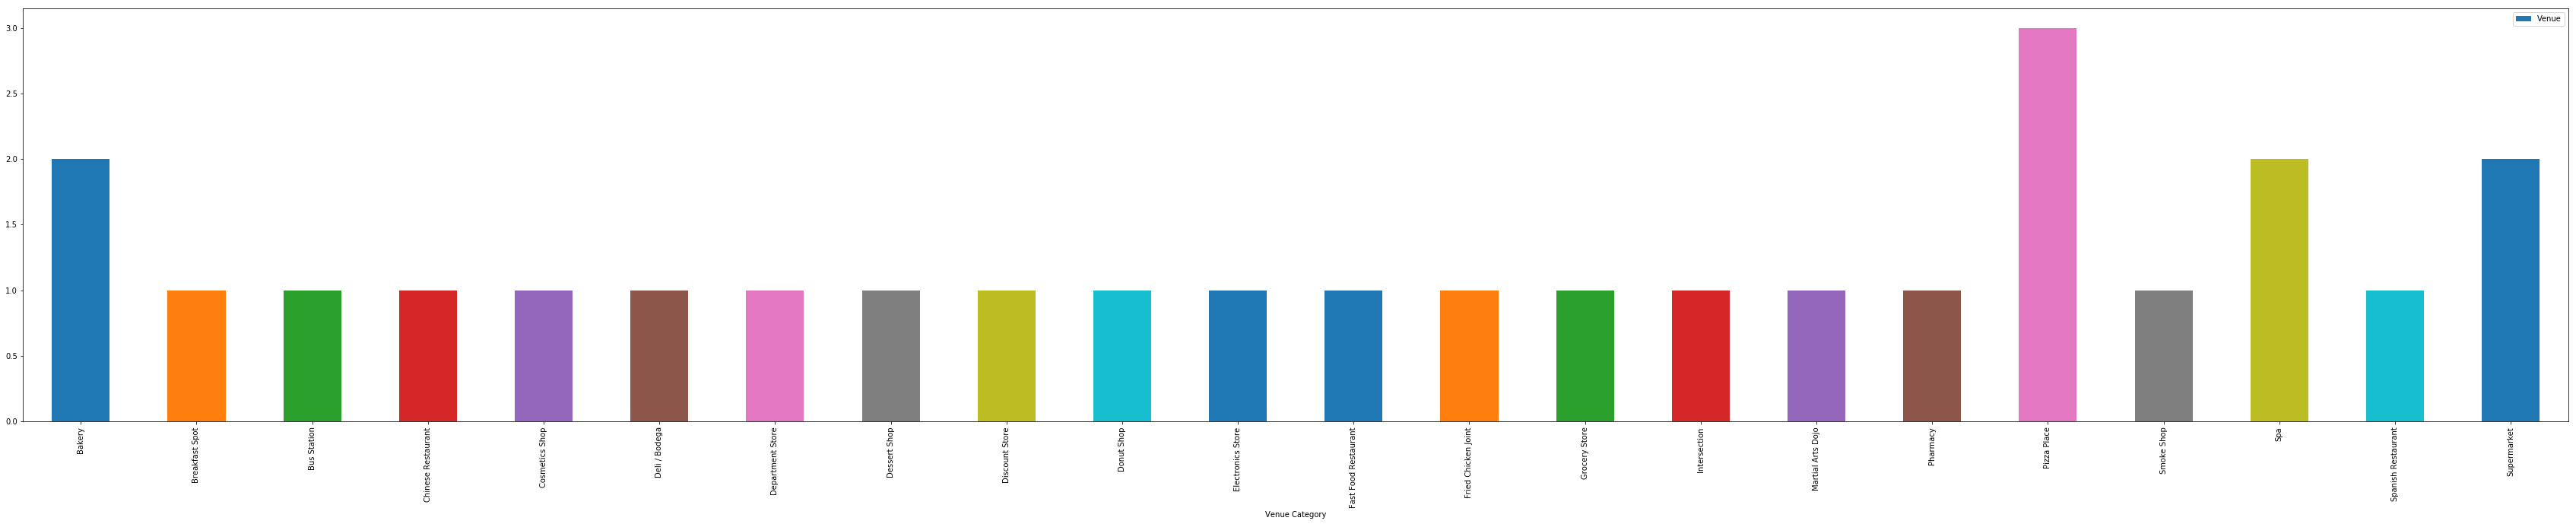

In [642]:
sampleNeighborhood=sample.loc[sample['Neighborhood']=='Allerton']
sampleNeighborhood.groupby('Venue Category').count().plot(kind='bar', y='Venue', use_index=True, figsize=(60,10))

Knowing that for this neighborhood 27 venues were collected from the foursquare database but are distributed in 22 unique categories. This lead to justify that if the mean of venues per neighborhood is 30, then is feasible to obtain at least the 10 most repetitive categories per neighborhood.

## Define the most common venues

In order to identify the most common venues for each neighborhood using the venues data from foursquare, **where 9039 venues were extracted with 416 unique categories**, calculating the categorical value for each unique category is necessary and then with the **categorical values of the venues** is possible to evaluate which are the probability of have that type of venue per neighborhood, and finally gather the **10 most common venues per each of the 306 neighborhoods.**

In [217]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [659]:
# set the number of common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NewYorkVenuesNeighborhood['Neighborhood']
# append the dataframe data
for ind in np.arange(NewYorkVenuesNeighborhood.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NewYorkVenuesNeighborhood.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Spa,Bakery,Breakfast Spot,Electronics Store,Grocery Store,Fried Chicken Joint,Spanish Restaurant,Bus Station
1,Annadale,Pizza Place,American Restaurant,Diner,Sports Bar,Park,Train Station,Restaurant,Deli / Bodega,Dance Studio,price nowNormal
2,Arden Heights,Pizza Place,Deli / Bodega,Coffee Shop,Pharmacy,price nowNormal,Farmers Market,Ethiopian Restaurant,Event Service,Event Space,Exhibit
3,Arlington,Bus Stop,Furniture / Home Store,Coffee Shop,price nowNormal,Food Truck,Fountain,Event Service,Event Space,Exhibit,Eye Doctor
4,Arrochar,Bus Stop,Deli / Bodega,Pizza Place,Italian Restaurant,price nowNormal,Athletics & Sports,Cosmetics Shop,Polish Restaurant,Sandwich Place,Outdoors & Recreation


## Cluster Neighborhoods

The **10 most common venues per neighborhood** will merge together with the **normalize average house price of today** per each neighborhood and will be the data set used to train a machine learning algorithm.

In [660]:
# creating the data for clustering algorithm
NewYorkVenuesNeighborhoodForCluster=RealEstateValue(NewYorkVenuesNeighborhood['Neighborhood'],NewYorkVenuesNeighborhood)

In [661]:
NewYorkVenuesNeighborhoodForCluster.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet 

## Classification Modeling 

Taking into account that the purpose of the algorithm is to identify the set of neighborhoods in New Yok that share similar venues around and similar average house price, the most promising machine learning that would accomplish with this requirement is the **k-means clustering.** This machine learning algorithm is design to have a **good performance with large dataset**, like the one used in this project; another reason to develop a K-means clustering is that the data **does not contain noise due to the massive categorical values**, for this reason there is no need to use algorithms robust to noise like DBSCAN (density based spatial clustering application with noise).

In [221]:
# set number of clusters
kclusters = 8

NewYorkClusters = NewYorkVenuesNeighborhoodForCluster.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NewYorkClusters)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([6, 4, 4, 3, 1, 6, 6, 1, 1, 6], dtype=int32)

This number of clusters was selected after trying different numbers from **5 to 20** and identify that the best clustering in order to avoid clusters with 1 neighborhood was **8 clusters.** 

In [222]:
NewYork_merged = neighborhoods

# merge New York data to add latitude/longitude for each neighborhood
NewYork_merged = NewYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
NewYork_merged = RealEstateValue(NewYork_merged['Neighborhood'],NewYork_merged)
NewYork_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,price nowNormal
0,Bronx,Allerton,40.865788,-73.859319,6.0,Pizza Place,Supermarket,Spa,Bakery,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station,Fast Food Restaurant,Smoke Shop,0.012022
1,Bronx,Baychester,40.866858,-73.835798,6.0,Electronics Store,Breakfast Spot,Donut Shop,Fried Chicken Joint,Spanish Restaurant,Moving Target,Supermarket,Boat or Ferry,Fast Food Restaurant,Mexican Restaurant,0.042995
2,Bronx,Bedford Park,40.870185,-73.885512,4.0,Diner,Deli / Bodega,Pizza Place,Chinese Restaurant,Supermarket,Mexican Restaurant,Sandwich Place,Food Truck,Park,Pub,0.017294
3,Bronx,Belmont,40.857277,-73.888452,1.0,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Liquor Store,Food & Drink Shop,Fish Market,Bar,Coffee Shop,0.046172
4,Bronx,Bronxdale,40.852723,-73.861726,1.0,Italian Restaurant,Deli / Bodega,Bank,Spanish Restaurant,Paper / Office Supplies Store,Chinese Restaurant,Mexican Restaurant,Eastern European Restaurant,Pizza Place,Gym,0.000000


The location data is merged with the venues data, that is compressed from more or less 30 venues per neighborhood to the 10 most common categories of those venues for each neighborhood. Finally, the location and venues data are merge with the normalize average price of a house in each neighborhood.

In [223]:
# modify the columns order
DataCluster=NewYork_merged
DataCluster.columns
# moving price now normal in the columns list
fixColumns= list(NewYork_merged.columns[:4]) + [NewYork_merged.columns[-1]] + list(NewYork_merged.columns[4:-1])
# modify the columns order in the dataframe
DataCluster=DataCluster[fixColumns]
DataCluster.dropna(axis=0,inplace=True)
DataCluster.head()

/Users/Marrugo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Borough,Neighborhood,Latitude,Longitude,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,0.012022,6.0,Pizza Place,Supermarket,Spa,Bakery,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station,Fast Food Restaurant,Smoke Shop
1,Bronx,Baychester,40.866858,-73.835798,0.042995,6.0,Electronics Store,Breakfast Spot,Donut Shop,Fried Chicken Joint,Spanish Restaurant,Moving Target,Supermarket,Boat or Ferry,Fast Food Restaurant,Mexican Restaurant
2,Bronx,Bedford Park,40.870185,-73.885512,0.017294,4.0,Diner,Deli / Bodega,Pizza Place,Chinese Restaurant,Supermarket,Mexican Restaurant,Sandwich Place,Food Truck,Park,Pub
3,Bronx,Belmont,40.857277,-73.888452,0.046172,1.0,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Liquor Store,Food & Drink Shop,Fish Market,Bar,Coffee Shop
4,Bronx,Bronxdale,40.852723,-73.861726,0.000000,1.0,Italian Restaurant,Deli / Bodega,Bank,Spanish Restaurant,Paper / Office Supplies Store,Chinese Restaurant,Mexican Restaurant,Eastern European Restaurant,Pizza Place,Gym


## Create folium map with the clustering neighborhoods

In order to visualize the cluster location and show the real estate information is necessary us the folium library

In [224]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(DataCluster['Latitude'], DataCluster['Longitude'],DataCluster['Borough'], DataCluster['Neighborhood'], DataCluster['Cluster Labels']):
    label = folium.Popup(str(bor)+','+str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    if cluster is None:
        break
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)],
            fill=True,
            fill_color=rainbow[int(cluster)],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results <a name="results"></a>

In order to examine each cluster classified with the K-means algorithm is necessary add the **real estate index** corresponding for each neighborhood in the cluster, then is possible make the plot of the map using folium to show the **location of each neighborhood** with a marker that contain the **average price of house today, the real estate index, and the depreciation of appreciation on the average price of the house in the last 3 months.**

Once each cluster have the complete information is possible to identify the maximum and minimum price of the cluster, to give an idea of the real estate price of these neighborhoods, and also to give a description of the most common venues of the cluster that among all neighborhoods in the cluster.


In [368]:
def clusterAnalysis (cluster,realestate):
    clusterA=cluster
    # get name of neighborhood per cluster
    for name in clusterA['Neighborhood']:
        # get the real estate values
        price=realestate.loc[realestate['Neighborhood'] == name][['price now','Real estate percentage 12month ago','Real estate percentage 3month ago','Real state index']]
        # get the index of the neighborhood in the data
        index=cluster.loc[cluster['Neighborhood']==name].index
        # add columns in the cluster data
        clusterA.at[index,'Real estate percentage 12month ago'] = price['Real estate percentage 12month ago'].values[0]
        clusterA.at[index,'Real estate percentage 3month ago'] = price['Real estate percentage 3month ago'].values[0]    
        clusterA.at[index,'price now'] = price['price now'].values[0]
        clusterA.at[index,'Real state index'] = price['Real state index'].values[0]
    #change the order of the columns in the cluster data
    fixedColumns=list(clusterA.columns[0:4])+list(clusterA.columns[-4:])+list(clusterA.columns[4:-4])
    clusterA=clusterA[fixedColumns]
    return clusterA

Once each cluster have the complete information is possible to identify the maximum and minimum price of the cluster, to five an idea of the real estate price of these neighborhoods, and also give a description of the most common venues of the cluster that have in common each neighborhood, finally is possible gie the visualization of the neighborhoods per cluster

In [656]:
def analysis(Cluster):
    #print the number of neighborhoods in the cluster
    print('The number of the neighborhoods in the cluster '+str(Cluster['Cluster Labels'].values[0])+' is {}'.format(Cluster.shape[0]))
    #print the maximum and minimum real estate value of the cluster
    print('where the maximum price is {}$,its percentage with respect max price in New york is {}'.format(Cluster['price now'].max(),round(Cluster['price nowNormal'].max(),4)))
    print('where the minimum price is {}$,its percentage with respect max price in New york is {}'.format(Cluster['price now'].min(),round(Cluster['price nowNormal'].min(),4)))
    print('\n')
    print('----------------------------------Neighborhoods common venues-----------------------------------------')
    # determine the most common neighborhoods
    count=0
    for column in Cluster[list(Cluster.columns[10:14])]:
        count+=1
        # convert the values and count the values of each column of the cluster in directory
        dic=Cluster[column].value_counts().to_dict()
        # sort the directory in the descending order
        dic=sorted(dic.iteritems(), key=operator.itemgetter(1),reverse=True)
        #pick the first 4 values 
        top=dic[0:5:]
        f=[]
        # save the 4 most common venues in a list
        for item in top:
            f.append(item[0])
        # convert the list of venues in a dataframe
        if count==1:
            falp=pd.DataFrame([item for item in f])
            falp.columns=[column]
        else:
            fp=pd.DataFrame([item for item in f])
            fp.columns=[column]
            # create a combine dataframe 
            falp.loc[:,column]=fp
    # print the dataframe 
    print tabulate(falp, headers=list(Cluster.columns[10:14]))

Defining the map with the neighborhood in the cluster 

In [409]:
# create map
def clustermap(latitude,longitude,zoom,cluster):
    mapcluster = folium.Map(location=[latitude, longitude], zoom_start=zoom)

    # add markers to the map
    markers_colors = []
    for lat, lon, bor, poi, cluster, price, inderel in zip(cluster['Latitude'], cluster['Longitude'],cluster['Borough'], cluster['Neighborhood'], cluster['Cluster Labels'],cluster['price now'],cluster['Real state index']):
        label = folium.Popup(str(bor)+', '+str(poi) + ', Cluster ' + str(cluster)+', with an average house price of '+str(price)+'$ \n and a real estate index with a '+str(inderel), parse_html=True)
        #print(cluster)
        if cluster is None:
            break
        else:
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[int(cluster)],
                fill=True,
                fill_color=rainbow[int(cluster)],
                fill_opacity=0.7).add_to(mapcluster)
    return mapcluster

## Cluster 0

In [657]:
Data0Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 0]
Cluster0=clusterAnalysis(Data0Cluster,percentage)
Cluster0.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Bronx,Morrisania,40.823592,-73.901506,-115.331429,0.000000,227500.0,Negative trend (-%) and a depreciation on the average price of -4.497% in the last 3 months.,0.007608,0.0,Discount Store,Bus Station,Fast Food Restaurant,Metro Station,Donut Shop,Grocery Store,Sandwich Place,American Restaurant,Liquor Store,Bowling Alley
14,Bronx,Eastchester,40.887556,-73.827806,-14.422189,-1.166694,337792.0,Positive trend (+%) and a depreciation on the average price of -1.167% in the last 3 months.,0.019726,0.0,Caribbean Restaurant,Bus Station,Diner,Deli / Bodega,Metro Station,Bus Stop,Platform,Donut Shop,Pizza Place,Seafood Restaurant
7,Bronx,Claremont Village,40.831428,-73.901199,-53.001924,-16.875893,339982.0,Positive trend (+%) and a depreciation on the average price of -16.876% in the last 3 months.,0.019967,0.0,Bakery,Chinese Restaurant,Deli / Bodega,Supermarket,Bus Station,Grocery Store,Caribbean Restaurant,Liquor Store,Gift Shop,Pizza Place
69,Brooklyn,Coney Island,40.574293,-73.988683,-20.981683,-5.643726,373583.0,Positive trend (+%) and a depreciation on the average price of -5.644% in the last 3 months.,0.023658,0.0,Monument / Landmark,Caribbean Restaurant,Cosmetics Shop,Pharmacy,Music Venue,Food Court,Gourmet Shop,Beach,Skating Rink,Theme Park Ride / Attraction
185,Queens,Far Rockaway,40.603134,-73.754980,-7.684995,-12.502447,423917.0,Negative trend (-%) and a depreciation on the average price of -12.502% in the last 3 months.,0.029189,0.0,Grocery Store,Deli / Bodega,Chinese Restaurant,Pizza Place,Pharmacy,Supermarket,Fried Chicken Joint,Breakfast Spot,Fast Food Restaurant,Sandwich Place
41,Bronx,Soundview,40.821012,-73.865746,12.973974,13.317656,424812.0,Positive trend (+%) and an appreciation on the average price of +13.318% in the last 3 months.,0.029287,0.0,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Bus Stop,Pharmacy,Liquor Store,Latin American Restaurant,Playground,Video Store,Discount Store
178,Queens,Cambria Heights,40.692775,-73.735269,-3.356632,-1.624454,442795.0,Positive trend (+%) and a depreciation on the average price of -1.624% in the last 3 months.,0.031263,0.0,Caribbean Restaurant,Cosmetics Shop,Discount Store,Flower Shop,Bus Station,Bus Stop,Gym / Fitness Center,Chinese Restaurant,Nightclub,Electronics Store
47,Bronx,Wakefield,40.894705,-73.847201,4.166649,1.264078,461522.0,Negative trend (-%) and an appreciation on the average price of +1.264% in the last 3 months.,0.033320,0.0,Food Truck,Ice Cream Shop,Caribbean Restaurant,Donut Shop,Sandwich Place,Laundromat,Dessert Shop,Pharmacy,Flea Market,Falafel Restaurant
50,Bronx,Williamsbridge,40.881039,-73.857446,3.272895,-7.635298,480217.0,Negative trend (-%) and a depreciation on the average price of -7.635% in the last 3 months.,0.035374,0.0,Nightclub,Bar,Caribbean Restaurant,Soup Place,Yoga Studio,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Factory
201,Queens,Jamaica Estates,40.716805,-73.787227,-92.868058,-16.995898,484917.0,Positive trend (+%) and a depreciation on the average price of -16.996% in the last 3 months.,0.035891,0.0,Intersection,Indian Restaurant,Eye Doctor,Bus Station,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory


In [658]:
analysis(Cluster0)

The number of the neighborhoods in the cluster 0.0 is 31
where the maximum price is 1260000.0$,its percentage with respect max price in New york is 0.121
where the minimum price is 227500.0$,its percentage with respect max price in New york is 0.0076


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Caribbean Restaurant     Chinese Restaurant       Fried Chicken Joint      Gym
 1  Chinese Restaurant       Caribbean Restaurant     Cosmetics Shop           Fast Food Restaurant
 2  Fried Chicken Joint      Supermarket              Diner                    Deli / Bodega
 3  Bus Station              Baseball Field           Caribbean Restaurant     Grocery Store
 4  Fast Food Restaurant     Bar                      Bus Station      

In [662]:
clustermap(latitude,longitude,11,Data0Cluster)

## Cluster 1

In [663]:
Data1Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 1]
Cluster1=clusterAnalysis(Data1Cluster,percentage)
Cluster1.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bronx,Bronxdale,40.852723,-73.861726,-23.981675,-3.685940,158250.0,Positive trend (+%) and a depreciation on the average price of -3.686% in the last 3 months.,0.000000,1.0,Italian Restaurant,Deli / Bodega,Bank,Spanish Restaurant,Paper / Office Supplies Store,Chinese Restaurant,Mexican Restaurant,Eastern European Restaurant,Pizza Place,Gym
197,Queens,Howard Beach,40.654225,-73.838138,-53.708179,-3.460782,252833.0,Positive trend (+%) and a depreciation on the average price of -3.461% in the last 3 months.,0.010392,1.0,Italian Restaurant,Deli / Bodega,Sandwich Place,Clothing Store,Pharmacy,Bagel Shop,Fast Food Restaurant,Tapas Restaurant,Market,Spa
31,Bronx,North Riverdale,40.908543,-73.904531,12.576279,-4.342238,259083.0,Negative trend (-%) and a depreciation on the average price of -4.342% in the last 3 months.,0.011078,1.0,Pizza Place,Italian Restaurant,Sushi Restaurant,Pharmacy,Coffee Shop,Bagel Shop,Donut Shop,Social Club,Bank,Mexican Restaurant
208,Queens,Little Neck,40.770826,-73.738898,-53.631127,-3.206543,265083.0,Positive trend (+%) and a depreciation on the average price of -3.207% in the last 3 months.,0.011738,1.0,Italian Restaurant,Chinese Restaurant,Spa,Bakery,Korean Restaurant,Coffee Shop,Japanese Restaurant,Shanghai Restaurant,Shipping Store,Deli / Bodega
171,Queens,Belle Harbor,40.576156,-73.854018,-93.648557,-11.080458,304482.0,Positive trend (+%) and a depreciation on the average price of -11.08% in the last 3 months.,0.016066,1.0,Beach,Deli / Bodega,Spa,Boutique,Mexican Restaurant,Donut Shop,Pharmacy,Bagel Shop,Bus Stop,Bakery
10,Bronx,Concourse,40.834284,-73.915589,9.585864,0.446047,314317.0,Negative trend (-%) and an appreciation on the average price of +0.446% in the last 3 months.,0.017147,1.0,Chinese Restaurant,Rental Car Location,Art Museum,Metro Station,Caribbean Restaurant,Liquor Store,Bakery,Pharmacy,Sandwich Place,Donut Shop
257,Staten Island,Egbertville,40.579119,-74.127272,-52.826260,-5.597863,327500.0,Positive trend (+%) and a depreciation on the average price of -5.598% in the last 3 months.,0.018595,1.0,Bagel Shop,Italian Restaurant,Cosmetics Shop,Dance Studio,Clothing Store,Field,Event Service,Event Space,Exhibit,Eye Doctor
256,Staten Island,Dongan Hills,40.588673,-74.096399,-52.826260,-5.597863,327500.0,Positive trend (+%) and a depreciation on the average price of -5.598% in the last 3 months.,0.018595,1.0,Pizza Place,Bank,Italian Restaurant,Pharmacy,Train Station,Jewelry Store,Tattoo Parlor,Sushi Restaurant,Fast Food Restaurant,Chinese Restaurant
172,Queens,Bellerose,40.728573,-73.720128,-38.141133,-13.480918,380167.0,Positive trend (+%) and a depreciation on the average price of -13.481% in the last 3 months.,0.024382,1.0,Pizza Place,Chinese Restaurant,Italian Restaurant,Flower Shop,Grocery Store,Motel,Mobile Phone Shop,Salon / Barbershop,Fast Food Restaurant,Diner
273,Staten Island,Mariner's Harbor,40.632546,-74.150085,8.266509,0.394244,380475.0,Negative trend (-%) and an appreciation on the average price of +0.394% in the last 3 months.,0.024416,1.0,Italian Restaurant,Deli / Bodega,Food,Other Repair Shop,Bus Stop,Athletics & Sports,Yoga Studio,Fast Food Restaurant,Event Service,Event Space


In [664]:
analysis(Cluster1)

The number of the neighborhoods in the cluster 1.0 is 50
where the maximum price is 1200000.0$,its percentage with respect max price in New york is 0.1145
where the minimum price is 158250.0$,its percentage with respect max price in New york is 0.0


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Italian Restaurant       Italian Restaurant       Italian Restaurant       Pizza Place
 1  Deli / Bodega            Deli / Bodega            Deli / Bodega            Convenience Store
 2  Pizza Place              Chinese Restaurant       Sandwich Place           Chinese Restaurant
 3  Bus Stop                 Pizza Place              Food                     Bakery
 4  Bagel Shop               Pharmacy                 Convenience Stor

In [665]:
clustermap(latitude,longitude,11,Data1Cluster)

## Cluster 2

In [666]:
Data2Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 2]
Cluster2=clusterAnalysis(Data2Cluster,percentage)
Cluster2.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
151,Manhattan,Soho,40.722184,-74.000657,-7.547170,0.566038,5300000.0,Positive trend (+%) and an appreciation on the average price of +0.566% in the last 3 months.,0.564919,2.0,Clothing Store,Women's Store,Boutique,Men's Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Shoe Store,Yoga Studio,Bakery
154,Manhattan,Tribeca,40.721522,-74.010683,-5.434783,1.268116,5520000.0,Positive trend (+%) and an appreciation on the average price of +1.268% in the last 3 months.,0.589090,2.0,Café,American Restaurant,Greek Restaurant,Boutique,Spa,Wine Bar,Park,Hotel,Chinese Restaurant,Salad Place
160,Manhattan,West Village,40.734434,-74.006180,3.891709,0.000000,5910000.0,Positive trend (+%) and a depreciation on the average price of -6.215% in the last 3 months.,0.631939,2.0,Italian Restaurant,Cosmetics Shop,Gastropub,Wine Bar,New American Restaurant,Speakeasy,French Restaurant,Cocktail Bar,Gourmet Shop,American Restaurant
149,Manhattan,Noho,40.723259,-73.988434,71.797753,27.528090,8900000.0,Negative trend (-%) and an appreciation on the average price of +27.528% in the last 3 months.,0.960447,2.0,Italian Restaurant,Cocktail Bar,Mexican Restaurant,Hotel,Coffee Shop,Rock Club,French Restaurant,Boutique,Deli / Bodega,Bookstore
138,Manhattan,Lenox Hill,40.768113,-73.958860,87.904968,45.248380,9260000.0,Negative trend (-%) and an appreciation on the average price of +45.248% in the last 3 months.,1.000000,2.0,Gym / Fitness Center,Gym,Burger Joint,Coffee Shop,Italian Restaurant,Sushi Restaurant,Art Gallery,Bakery,Turkish Restaurant,Cocktail Bar
153,Manhattan,Sutton Place,40.760280,-73.963556,87.904968,45.248380,9260000.0,Negative trend (-%) and an appreciation on the average price of +45.248% in the last 3 months.,1.000000,2.0,Gym / Fitness Center,Indian Restaurant,Italian Restaurant,Juice Bar,Gym,Furniture / Home Store,Yoga Studio,Mexican Restaurant,Sushi Restaurant,Bar


In [667]:
analysis(Cluster2)

The number of the neighborhoods in the cluster 2.0 is 6
where the maximum price is 9260000.0$,its percentage with respect max price in New york is 1.0
where the minimum price is 5300000.0$,its percentage with respect max price in New york is 0.5649


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Gym / Fitness Center     Cocktail Bar             Greek Restaurant         Coffee Shop
 1  Italian Restaurant       American Restaurant      Burger Joint             Boutique
 2  Clothing Store           Gym                      Gastropub                Hotel
 3  Café                     Indian Restaurant        Boutique                 Wine Bar


In [668]:
clustermap(latitude,longitude,11,Data2Cluster)

## Cluster 3

In [669]:
Data3Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 3]
Cluster3=clusterAnalysis(Data3Cluster,percentage)
Cluster3.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
261,Staten Island,Fox Hills,40.617311,-74.081740,0.145253,-16.772895,298100.0,Negative trend (-%) and a depreciation on the average price of -16.773% in the last 3 months.,0.015365,3.0,Bus Stop,Sandwich Place,Food,Grocery Store,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
286,Staten Island,Randall Manor,40.635630,-74.098051,0.000000,0.000000,315000.0,Negative trend (-%) and a depreciation on the average price of -4.027% in the last 3 months.,0.017222,3.0,Bus Stop,Bagel Shop,Park,Deli / Bodega,Pizza Place,Playground,Fast Food Restaurant,Event Service,Event Space,Exhibit
281,Staten Island,Park Hill,40.609190,-74.080157,-8.455156,-5.117763,326842.0,Positive trend (+%) and a depreciation on the average price of -5.118% in the last 3 months.,0.018523,3.0,Bus Stop,Gym / Fitness Center,Athletics & Sports,Hotel,Coffee Shop,Yoga Studio,Fast Food Restaurant,Event Service,Event Space,Exhibit
245,Staten Island,Arlington,40.635325,-74.165104,8.266509,0.394244,380475.0,Negative trend (-%) and an appreciation on the average price of +0.394% in the last 3 months.,0.024416,3.0,Bus Stop,Furniture / Home Store,Coffee Shop,Field,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
275,Staten Island,New Brighton,40.640615,-74.087017,18.804687,16.951845,426750.0,Negative trend (-%) and an appreciation on the average price of +16.952% in the last 3 months.,0.029500,3.0,Bus Stop,Deli / Bodega,Park,Playground,Bowling Alley,Convenience Store,Botanical Garden,Discount Store,Farmers Market,Field
248,Staten Island,Bloomfield,40.605779,-74.187256,78.478261,0.000000,460000.0,Negative trend (-%) and a depreciation on the average price of -1.273% in the last 3 months.,0.033153,3.0,Recreation Center,Discount Store,Park,Theme Park,Bus Stop,Food & Drink Shop,Food,Event Service,Event Space,Exhibit
266,Staten Island,Greenridge,40.555295,-74.170794,6.611570,-2.238223,484000.0,Negative trend (-%) and a depreciation on the average price of -2.238% in the last 3 months.,0.035790,3.0,Bagel Shop,Construction & Landscaping,Pizza Place,Diner,Bus Stop,Food Stand,Fast Food Restaurant,Event Service,Event Space,Exhibit
294,Staten Island,South Beach,40.580247,-74.079553,-18.459433,-13.859319,508683.0,Positive trend (+%) and a depreciation on the average price of -13.859% in the last 3 months.,0.038502,3.0,Pier,Deli / Bodega,Beach,Athletics & Sports,Bus Stop,Yoga Studio,Field,Event Space,Exhibit,Eye Doctor
279,Staten Island,Oakwood,40.558462,-74.121566,2.618475,0.496533,558875.0,Negative trend (-%) and an appreciation on the average price of +0.497% in the last 3 months.,0.044016,3.0,Bar,Bus Stop,Yoga Studio,Field,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
291,Staten Island,Sandy Ground,40.541140,-74.217766,-0.993549,0.309783,651100.0,Positive trend (+%) and an appreciation on the average price of +0.31% in the last 3 months.,0.054149,3.0,Intersection,Market,Liquor Store,Bus Stop,Art Gallery,Field,Event Service,Event Space,Exhibit,Eye Doctor


In [670]:
analysis(Cluster3)

The number of the neighborhoods in the cluster 3.0 is 11
where the maximum price is 1020000.0$,its percentage with respect max price in New york is 0.0947
where the minimum price is 298100.0$,its percentage with respect max price in New york is 0.0154


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Bus Stop                 Deli / Bodega            Park                     Field
 1  Bagel Shop               Sandwich Place           Liquor Store             Diner
 2  Bar                      Bagel Shop               Food                     Athletics & Sports
 3  Recreation Center        Gym / Fitness Center     Pizza Place              Hotel
 4  Intersection             Furniture / Home Store   Coffee Shop              Pizza P

In [671]:
clustermap(latitude,longitude,11,Data3Cluster)

## Cluster 4

In [672]:
Data4Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 4]
Cluster4=clusterAnalysis(Data4Cluster,percentage)
Cluster4.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
175,Queens,Briarwood,40.710935,-73.811748,-31.479561,-2.382934,234333.0,Positive trend (+%) and a depreciation on the average price of -2.383% in the last 3 months.,0.008359,4.0,Deli / Bodega,Food Truck,Mexican Restaurant,Coffee Shop,Playground,Fast Food Restaurant,Bus Station,Arts & Crafts Store,Pet Store,Indian Restaurant
51,Bronx,Woodlawn,40.898273,-73.867315,-66.307477,4.527098,244903.0,Positive trend (+%) and an appreciation on the average price of +4.527% in the last 3 months.,0.009520,4.0,Deli / Bodega,Playground,Pub,Pizza Place,Plaza,Bar,Supermarket,Bus Station,Bus Stop,Rental Car Location
32,Bronx,Norwood,40.877224,-73.879391,3.762997,8.566925,248047.0,Positive trend (+%) and an appreciation on the average price of +8.567% in the last 3 months.,0.009866,4.0,Pizza Place,Park,Pharmacy,American Restaurant,Bank,Coffee Shop,Mobile Phone Shop,Mexican Restaurant,Liquor Store,Fast Food Restaurant
22,Bronx,Kingsbridge Heights,40.870392,-73.901523,11.314287,2.903812,315654.0,Negative trend (-%) and an appreciation on the average price of +2.904% in the last 3 months.,0.017294,4.0,Pizza Place,Coffee Shop,Spanish Restaurant,Chinese Restaurant,Supermarket,Fried Chicken Joint,Bus Station,Check Cashing Service,Park,Mexican Restaurant
2,Bronx,Bedford Park,40.870185,-73.885512,11.314287,2.903812,315654.0,Negative trend (-%) and an appreciation on the average price of +2.904% in the last 3 months.,0.017294,4.0,Diner,Deli / Bodega,Pizza Place,Chinese Restaurant,Supermarket,Mexican Restaurant,Sandwich Place,Food Truck,Park,Pub
183,Queens,Edgemere,40.595642,-73.776133,11.776175,-0.023976,379546.0,Negative trend (-%) and a depreciation on the average price of -0.024% in the last 3 months.,0.024314,4.0,Pizza Place,Metro Station,Asian Restaurant,Scenic Lookout,Farm,Gift Shop,Bus Station,Skate Park,Deli / Bodega,Park
284,Staten Island,Port Richmond,40.633669,-74.129434,-5.103052,-0.521785,383300.0,Positive trend (+%) and a depreciation on the average price of -0.522% in the last 3 months.,0.024726,4.0,Mexican Restaurant,Rental Car Location,Deli / Bodega,Pizza Place,Donut Shop,Bus Stop,Martial Arts Dojo,Flea Market,Food & Drink Shop,Ethiopian Restaurant
176,Queens,Broad Channel,40.603027,-73.820055,18.301672,51.083591,403750.0,Positive trend (+%) and an appreciation on the average price of +51.084% in the last 3 months.,0.026973,4.0,Pizza Place,Deli / Bodega,Other Nightlife,Dive Bar,Yoga Studio,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
258,Staten Island,Elm Park,40.630147,-74.141817,9.052216,2.876765,405525.0,Negative trend (-%) and an appreciation on the average price of +2.877% in the last 3 months.,0.027168,4.0,Italian Restaurant,American Restaurant,Ice Cream Shop,Deli / Bodega,Pizza Place,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space
290,Staten Island,Rossville,40.549404,-74.215729,-5.143822,-0.241109,414750.0,Positive trend (+%) and a depreciation on the average price of -0.241% in the last 3 months.,0.028181,4.0,Pizza Place,Bagel Shop,Deli / Bodega,Pool,Dry Cleaner,Liquor Store,Grocery Store,Ice Cream Shop,Chinese Restaurant,Convenience Store


In [673]:
analysis(Cluster4)

The number of the neighborhoods in the cluster 4.0 is 37
where the maximum price is 1020000.0$,its percentage with respect max price in New york is 0.0947
where the minimum price is 234333.0$,its percentage with respect max price in New york is 0.0084


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Pizza Place              Deli / Bodega            Deli / Bodega            Pizza Place
 1  Deli / Bodega            Park                     Pizza Place              Deli / Bodega
 2  Pharmacy                 Coffee Shop              Supermarket              Pharmacy
 3  Bagel Shop               American Restaurant      Bank                     Spanish Restaurant
 4  Irish Pub                Grocery Store            Ice Cream Shop 

In [674]:
clustermap(latitude,longitude,11,Data4Cluster)

## Cluster 5

In [675]:
Data5Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 5]
Cluster5=clusterAnalysis(Data5Cluster,percentage)
Cluster5.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,Brooklyn,Prospect Heights,40.676822,-73.964859,-13.259669,2.209945,1810000.0,Positive trend (+%) and an appreciation on the average price of +2.21% in the last 3 months.,0.181476,5.0,Bar,Thai Restaurant,Wine Shop,Bakery,Gourmet Shop,Mexican Restaurant,Cocktail Bar,Coffee Shop,Beer Bar,Southern / Soul Food Restaurant
109,Brooklyn,Red Hook,40.676253,-74.012759,43.455497,4.188482,1910000.0,Negative trend (-%) and an appreciation on the average price of +4.188% in the last 3 months.,0.192463,5.0,Art Gallery,Seafood Restaurant,Park,Flower Shop,American Restaurant,Bar,Farm,Bagel Shop,Café,Ice Cream Shop
84,Brooklyn,Fulton Ferry,40.703281,-73.995508,2.512563,6.030151,1990000.0,Positive trend (+%) and an appreciation on the average price of +6.03% in the last 3 months.,0.201253,5.0,Park,American Restaurant,Ice Cream Shop,Scenic Lookout,Café,Coffee Shop,Bakery,Bridge,Playground,Hotel Bar
74,Brooklyn,Dumbo,40.703176,-73.988753,1.913876,-2.392344,2090000.0,Negative trend (-%) and a depreciation on the average price of -2.392% in the last 3 months.,0.212239,5.0,Coffee Shop,Park,Bookstore,Scenic Lookout,Bakery,American Restaurant,Gym,Boxing Gym,Playground,Italian Restaurant
95,Brooklyn,Manhattan Terrace,40.614433,-73.957438,1.913876,-2.392344,2090000.0,Negative trend (-%) and a depreciation on the average price of -2.392% in the last 3 months.,0.212239,5.0,Pizza Place,Ice Cream Shop,Donut Shop,Café,Chinese Restaurant,Pharmacy,Bank,Eastern European Restaurant,Bagel Shop,Liquor Store
142,Manhattan,Manhattan Valley,40.797307,-73.964286,-3.603604,0.900901,2220000.0,Positive trend (+%) and an appreciation on the average price of +0.901% in the last 3 months.,0.226522,5.0,Coffee Shop,Pizza Place,Indian Restaurant,Yoga Studio,Mexican Restaurant,Deli / Bodega,French Restaurant,Café,Bar,Thai Restaurant
73,Brooklyn,Downtown,40.690844,-73.983463,4.347826,2.608696,2300000.0,Negative trend (-%) and an appreciation on the average price of +2.609% in the last 3 months.,0.235312,5.0,Burger Joint,Sandwich Place,Coffee Shop,Grocery Store,Bagel Shop,Bar,Bubble Tea Shop,Performing Arts Venue,Chinese Restaurant,Gym
87,Brooklyn,Gowanus,40.673931,-73.994441,29.487179,2.564103,2340000.0,Negative trend (-%) and an appreciation on the average price of +2.564% in the last 3 months.,0.239707,5.0,Bar,Italian Restaurant,Deli / Bodega,Gym / Fitness Center,Coffee Shop,Furniture / Home Store,Art Gallery,Wine Shop,Chinese Restaurant,Mexican Restaurant
78,Brooklyn,East Williamsburg,40.708492,-73.938858,5.833333,0.833333,2400000.0,Negative trend (-%) and an appreciation on the average price of +0.833% in the last 3 months.,0.246299,5.0,Bar,Deli / Bodega,Mexican Restaurant,Cocktail Bar,Coffee Shop,Café,Concert Hall,Bakery,Music Venue,Donut Shop
114,Brooklyn,South Side,40.710861,-73.958001,5.833333,0.833333,2400000.0,Negative trend (-%) and an appreciation on the average price of +0.833% in the last 3 months.,0.246299,5.0,Bar,American Restaurant,Yoga Studio,Chinese Restaurant,Pizza Place,South American Restaurant,Wine Bar,Burger Joint,Japanese Restaurant,Mexican Restaurant


In [676]:
analysis(Cluster5)

The number of the neighborhoods in the cluster 5.0 is 24
where the maximum price is 4720000.0$,its percentage with respect max price in New york is 0.5012
where the minimum price is 1810000.0$,its percentage with respect max price in New york is 0.1815


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Italian Restaurant       American Restaurant      Wine Shop                Coffee Shop
 1  Bar                      Bakery                   Italian Restaurant       Hotel
 2  Coffee Shop              Coffee Shop              Deli / Bodega            Scenic Lookout
 3  Pizza Place              Nightclub                Cocktail Bar             Spa
 4  Ice Cream Shop           Steakhouse               Coffee Shop              Cockta

In [677]:
clustermap(latitude,longitude,11,Data5Cluster)

## Cluster 6

In [678]:
Data6Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 6]
Cluster6=clusterAnalysis(Data6Cluster,percentage)
Cluster6.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Bronx,Parkchester,40.837938,-73.856003,14.675415,2.618448,163532.0,Negative trend (-%) and an appreciation on the average price of +2.618% in the last 3 months.,0.000580,6.0,Pizza Place,Supermarket,American Restaurant,Bank,Asian Restaurant,Women's Store,Shoe Store,Gym,Martial Arts Dojo,Mattress Store
18,Bronx,Fordham,40.860997,-73.896427,-58.184818,0.733553,227250.0,Positive trend (+%) and an appreciation on the average price of +0.734% in the last 3 months.,0.007581,6.0,Donut Shop,Mobile Phone Shop,Shoe Store,Fast Food Restaurant,Bank,Pizza Place,Pharmacy,Supplement Shop,Electronics Store,Plaza
0,Bronx,Allerton,40.865788,-73.859319,-55.012385,2.646572,267667.0,Positive trend (+%) and an appreciation on the average price of +2.647% in the last 3 months.,0.012022,6.0,Pizza Place,Supermarket,Spa,Bakery,Breakfast Spot,Fried Chicken Joint,Spanish Restaurant,Bus Station,Fast Food Restaurant,Smoke Shop
267,Staten Island,Grymes Hill,40.624185,-74.087248,0.145253,-16.772895,298100.0,Negative trend (-%) and a depreciation on the average price of -16.773% in the last 3 months.,0.015365,6.0,Dog Run,Basketball Court,Yoga Studio,English Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
144,Manhattan,Marble Hill,40.876551,-73.910660,-108.770903,0.000000,299000.0,Positive trend (+%) and an appreciation on the average price of +21.736% in the last 3 months.,0.015464,6.0,Coffee Shop,Discount Store,Video Game Store,Shoe Store,Big Box Store,Gym,Seafood Restaurant,Bank,Sandwich Place,Pharmacy
228,Queens,Rockaway Park,40.580343,-73.841534,-93.648557,-11.080458,304482.0,Positive trend (+%) and a depreciation on the average price of -11.08% in the last 3 months.,0.016066,6.0,Ice Cream Shop,Beach,Steakhouse,Bank,Pizza Place,Yoga Studio,Diner,French Restaurant,Board Shop,Smoke Shop
227,Queens,Rockaway Beach,40.582802,-73.822361,-93.648557,-11.080458,304482.0,Positive trend (+%) and a depreciation on the average price of -11.08% in the last 3 months.,0.016066,6.0,Beach,Pizza Place,BBQ Joint,Latin American Restaurant,Seafood Restaurant,Metro Station,Arepa Restaurant,Brazilian Restaurant,Bus Station,Ice Cream Shop
214,Queens,Neponsit,40.572037,-73.857547,-93.648557,-11.080458,304482.0,Positive trend (+%) and a depreciation on the average price of -11.08% in the last 3 months.,0.016066,6.0,Beach,Bar,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
193,Queens,Hammels,40.587338,-73.805530,-93.648557,-11.080458,304482.0,Positive trend (+%) and a depreciation on the average price of -11.08% in the last 3 months.,0.016066,6.0,Beach,Southern / Soul Food Restaurant,Bus Station,Food Truck,Shoe Store,Fast Food Restaurant,Café,Dog Run,Bus Stop,Diner
278,Staten Island,New Springville,40.594252,-74.164960,-35.727926,-4.637188,310533.0,Positive trend (+%) and a depreciation on the average price of -4.637% in the last 3 months.,0.016731,6.0,Pizza Place,Chinese Restaurant,Bus Stop,Donut Shop,Grocery Store,Martial Arts Dojo,Flower Shop,Pharmacy,Mobile Phone Shop,Liquor Store


In [679]:
analysis(Cluster6)

The number of the neighborhoods in the cluster 6.0 is 142
where the maximum price is 1990000.0$,its percentage with respect max price in New york is 0.2013
where the minimum price is 163532.0$,its percentage with respect max price in New york is 0.0006


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Pizza Place              Pizza Place              Donut Shop               Bank
 1  Bar                      Coffee Shop              Bank                     Pizza Place
 2  Coffee Shop              Italian Restaurant       Pizza Place              Donut Shop
 3  Pharmacy                 Supermarket              Bakery                   Fast Food Restaurant
 4  Café                     American Restaurant      Bar                

In [680]:
clustermap(latitude,longitude,11,Data6Cluster)

## Cluster 7

In [681]:
Data7Cluster=DataCluster.loc[DataCluster['Cluster Labels'] == 7]
Cluster7=clusterAnalysis(Data7Cluster,percentage)
Cluster7.sort_values(['price nowNormal'])

,Borough,Neighborhood,Latitude,Longitude,Real estate percentage 12month ago,Real estate percentage 3month ago,price now,Real state index,price nowNormal,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bronx,Clason Point,40.806551,-73.854144,0.629423,2.551384,439291.0,Positive trend (+%) and an appreciation on the average price of +2.551% in the last 3 months.,0.030878,7.0,Park,South American Restaurant,Grocery Store,Boat or Ferry,Pool,Bus Stop,Scenic Lookout,Yoga Studio,Event Service,Event Space
168,Queens,Bayswater,40.611322,-73.765968,17.622132,-5.468582,466300.0,Negative trend (-%) and a depreciation on the average price of -5.469% in the last 3 months.,0.033845,7.0,Tennis Court,Park,Playground,Yoga Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
231,Queens,Somerville,40.597711,-73.796648,25.795003,0.000000,497608.0,Negative trend (-%) and a depreciation on the average price of -12.502% in the last 3 months.,0.037285,7.0,Park,Yoga Studio,Irish Pub,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
298,Staten Island,Todt Hill,40.597069,-74.111329,27.339118,-3.921569,1020000.0,Negative trend (-%) and a depreciation on the average price of -3.922% in the last 3 months.,0.094680,7.0,Park,Yoga Studio,Irish Pub,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant


In [682]:
analysis(Cluster7)

The number of the neighborhoods in the cluster 7.0 is 4
where the maximum price is 1020000.0$,its percentage with respect max price in New york is 0.0947
where the minimum price is 439291.0$,its percentage with respect max price in New york is 0.0309


----------------------------------Neighborhoods common venues-----------------------------------------
    1st Most Common Venue    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue
--  -----------------------  -----------------------  -----------------------  -----------------------
 0  Park                     Yoga Studio              Irish Pub                Ethiopian Restaurant
 1  Tennis Court             Park                     Playground               Yoga Studio


In [683]:
clustermap(latitude,longitude,11,Data7Cluster)

After the K-means clustering algorithm, **8 clusters** were obtained and after analyzing each cluster is possible identify that the algorithm top priority features for classification was the normalize average price of the house per neighborhood, because from the 8 cluster is possible to distinguish the following **socio-economy insights:**

Cluster| # neighborhoods per cluster | Minimum average price | Percentage of similarity | Maximum average price |  	Percentage of similarity | Economy | Venues relationship
------- | ------- | ----|----- |------ | ------|-------|----- 
0	|31	|227,500	|0.76	|1’260,000	|12.1	|Low price to medium price	|Fast food and restaurants venues 
1	|50	|158,250	|0.0	|1’200,000	|11,45	|Low price to medium price	|Commercial venues with food restaurants
2	|6	|5’300,000	|56,49	|9’260,000	|100	|High price	|Boutique and unique restaurants
3	|11	|228,100	|1.53	|1’020,000  |9.46	|Low price 	|Bust stop, industrial and commercial venues
4	|37	|234,333	|0.83	|1’020,000	|9.46	|Low price 	|Food and commercial venues
5	|24	|1’810,000	|18.14	|4’720,000	|50,11	|Medium price to high price	|Night live venues and restaurant venues
6	|142	|163,532	|0.058	|1’990,000	|20.12	|Low price to medium price	|Popular venues (supermarket, restaurant, pharmacy, fast food)
7	|4	|439,291	|3.087	|1’020,000	|9.46	|Low price 	|Open yard venues (tennis court, park, Playgorunds)

# Discussion <a name="discussion"></a>

For the **Economy insights** was necessary divide the average house price in **3 categories (low, medium, high).** Where the **highest average house price** in New York is about **9’260,000**, and because this value corresponds to a limited number of neighborhoods, the category begins from more than **4’000,000**, the **medium average house price** was set from **1’020,000** up to **4’000,000**, while **lower average price** is below of **1’020,000.**

For the **social insights** is possible identify that **cluster 0** have neighborhoods that have venues related with food and fast food and usually are located in the **center of the boroughs of New York.** This type of venues and location can define that this cluster is for neighborhoods with **high density of housing** with average price that are from low up to the beginning of medium categories.

The **cluster 1** have venues related with **commercial activities and fast food venues**, the neighborhoods related in this cluster are located approximately in the **borders of the borough of New York** except by Staten Island, this indicates that the average price of house in this neighborhood are between lower and the beginning of medium category, due to the distance to the center of the boroughs.

The **cluster 2** have venues related with **luxury activities** like boutique or expensive restaurant, those types of venues defined the neighborhoods involved in this cluster to be **exclusive** in New York, and a justification of this is that these neighborhoods have the **most expensive average house price** in all New York and are located exactly in Manhattan.

The **cluster 3** have venues related with **commercial activities, green areas and entertainment activities**, but the average price of the house in these neighborhoods are in the lower category price like the neighborhoods of the **cluster 1**, but with the difference that these neighborhoods are located in the borough of Staten Island.

The **cluster 4** have venues related with **food** like restaurants, which indicates that these neighborhoods are characterized to be near to **working places or event places** that gather huge amount of people, but although the neighborhoods are distributed in strategic places around the boroughs of New York the average house price is in the lower category.

The **cluster 5** have venues related with **night live** as clubs, bar, cocktail and expensive restaurants, which characterized these neighborhoods to be in the **most popular zone for party or hangout in New York**, for this reason the average price of the house is between the medium and high categories.

The **cluster 6** have venues related with **popular zones of New York with high residential density**, this means that **the venues are mixed** in the way that is possible to have restaurants, banks, pharmacy and diverse types of venues, for this reason this cluster have the bigger number of neighborhoods but all of them have an average house price between low and half of the medium categories.

The **cluster 7** have venues related with **outside activities** like parks, gyms and playgrounds, for this characteristic these neighborhoods are not included in the **clusters 3 or 4**, these neighborhoods have an average house price of low price to the beginning of the medium category and are distributed in different boroughs in New York.

The clustering made in the project allows to separate the **306 neighborhoods** in New York by social-economic features have a good dispersion of the neighborhoods **avoiding cluster with all the neighborhoods or with just 1**, in addition, the result support that the project can be a good resource to **identify different zones** that share same characteristics according with the current neighborhood that the client likes or even according with the venues and average price that the client prefer. 

In addition to these **social-economic** features the project can be complement with crime information of each neighborhood, to include **safety index** in the clustering algorithm, or even can include **current sales information** for each neighborhood from a commercial database like the New York Times listings, in order to improve the value obtained by the client from this project.

# Conclusion <a name="conclusion"></a>

Taking into account that from the point of view of buyers a new client with the intention of buy a house, the first challenge to affront is actually **finding a suitable home to move to**, in terms of average house price and the location (venues near of the house). This project reached a first step in a solution of **help the client to find a suitable house zone for buying, based on the venues of each neighborhood and the average price of a house for the city of New York.**

The project made an **unsupervised analysis of the neighborhoods in New York**, using **K-means clustering** to found **8 Clusters** that are not just divide the neighborhoods according with location or the average house price, but also based on the unlabeled data of the **venues around of 500 meters of the neighborhood.** 

The machine learning algorithm identified cluster that are compose by neighborhoods with lower average price and are located in zones near to the center of boroughs of New York, identify the neighborhoods with extreme high average house price and luxury venues near in other cluster, also identify medium to high average house price neighborhoods that have near night live venues.

The algorithm was able to discriminate the neighborhoods with a lower and the beginning of medium average house price that correspond more than **70% of the neighborhoods in New York**, in 6 different clusters depending in if the neighborhoods are in the border of the borough, are located near to work places, in the center of borough or just with high residential building density.

In that order the ideas the project was **able to cluster all neighborhoods in New York based on Social-economic features**, which ones help the client to **find a suitable zone for house acquisition based on the type of venues that the client preferred to be near of the house and/or the desired location, because with this information was possible identify the cluster that contains neighborhoods which those features.**

Once the cluster was selected, the information displayed per cluster was in **dataframe format** and **folium map format**, compose by the borough, neighborhood, latitude, longitude of each neighborhood in the cluster, also the percentage of depreciation or appreciation of the average price of a house today with respect the values gathered 12 months ago and 3 months ago and the real estate index in the average price of the house to increase or decrease with the past of the time; **allowing the user to choose among the list** which zone are more profitable for buying a house based in the zone with a **real estate index positive and appreciation with time**, or just choose the zone that **adjust to the budget of the user**, or just the zone with some **type of desirable venues.**

## Future directions 


Although, the project identified the zone more suitable for buying a house depending in the venues around the neighborhood and the average house price of them, the project does not include **information like crime rate**, that can include another feature like **safety index**, that will lead to have a more specific neighborhoods separation in more clusters given a **more refined result.** 

Another type of information that can improve the project is the **house sales information**, that could be the definite next step in the project to **help the user no just to find a suitable zone based in his desired venues and budget, but also find a house offer using the sales options per neighborhood.**
